In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [91]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

results_dir = os.path.join(data_dir, 'results')

figures_dir = os.path.join(data_dir, 'figures')



results_basecase_summer = pd.read_csv(os.path.join(results_dir, 'results_basecase_summer.csv'),sep=',')
results_basecase_winter = pd.read_csv(os.path.join(results_dir, 'results_basecase_winter.csv'), sep=',')
results_case_1_winter = pd.read_csv(os.path.join(results_dir, 'results_case_1_winter.csv'), sep=',')
results_case_2_summer = pd.read_csv(os.path.join(results_dir,'results_case_2_summer.csv'), sep=',')
results_case_2_winter = pd.read_csv(os.path.join(results_dir,'results_case_2_winter.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(results_dir,'results_case_3_summer.csv'), sep=',')
results_case_3_winter = pd.read_csv(os.path.join(results_dir,'results_case_3_winter.csv'), sep=',')

print(max(results_case_3_winter['EV_V2H']))

3.8763856040347577


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

def plot_ev_soc_with_price(
    df_dict,
    title="EV SOC with Spot Prices",
    save_filename="SOC_with_price.png",
    max_time=24 * 3,  # 3 days
):
    # Use base case for spot price reference
    base_df = df_dict["Base Case"]
    base_df['timestamp'] = pd.to_datetime(base_df['timestamp'])
    
    case_1_df = df_dict["Case 1"]
    case_2_df = df_dict["Case 2"]
    case_3_df = df_dict["Case 3"]

    timestamps = base_df['timestamp'][:max_time]
    spotprice = base_df['Spotmarket_(EUR/kWh)'][:max_time] if 'Spotmarket_(EUR/kWh)' in base_df.columns else [0] * max_time

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot SOC for each case
    palette = sns.color_palette("tab10", n_colors=len(df_dict))
    for i, (label, df) in enumerate(df_dict.items()):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        ax1.plot(
            df['timestamp'][:max_time],
            df['EV_SOC'][:max_time],
            label=label,
            linewidth=2,
            color=palette[i]
        )

    ax1.set_xlabel("Date")
    ax1.set_ylabel("State of Charge (SOC)")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.tick_params(axis='x', rotation=45)
    # Disable grid lines on all axes
    ax1.grid(False) 



    # Spot price
    ax2 = ax1.twinx()
    ax2.plot(timestamps, spotprice, linestyle='--', color='#a52a2a', label="Spot Price", linewidth=1.5)
    ax2.set_ylabel("Spot Price (EUR/kWh)", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc='upper left',
        fontsize=9
    )

    plt.title(title)
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)

    plt.show()




In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

def plot_ev_soc_and_charging_side_by_side(
    df_dict,
    title_left="EV SOC with Spot Prices",
    title_right="EV Dynamics, Case 3",
    save_filename="SOC_and_EV_dynamics_side_by_side.png",
    max_time=24 * 3,  # 3 days
    ev_capacity_kwh=70
):
    base_df = df_dict["Base Case"]
    case_3 = df_dict['Case 3']
    base_df['timestamp'] = pd.to_datetime(base_df['timestamp'])
    timestamps = base_df['timestamp'][:max_time]
    spotprice = base_df['Spotmarket_(EUR/kWh)'][:max_time]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

    all_handles = []
    all_labels = []

    # ---- LEFT PLOT: EV SOC (%) ---- #
    palette = sns.color_palette("tab10", n_colors=len(df_dict))
    for i, (label, df) in enumerate(df_dict.items()):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        soc_line, = ax1.plot(
            df['timestamp'][:max_time],
            df['EV_SOC'][:max_time] / ev_capacity_kwh * 100,
            label=f"SOC – {label}",
            linewidth=2,
            color=palette[i]
        )
        all_handles.append(soc_line)
        all_labels.append(f"SOC – {label}")

    ax1.set_title(title_left)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("State of Charge (SOC %)")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.tick_params(axis='x', rotation=0)
    ax1.grid(False)

    # Spot price axis on LEFT (hidden ticks and labels)
    ax1b = ax1.twinx()
    spot_line_left, = ax1b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax1b.set_ylabel("")
    ax1b.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)

    # ---- RIGHT PLOT ---- #
    soc = case_3['EV_SOC'][:max_time] / ev_capacity_kwh * 100
    charging = case_3['EV_Charging'][:max_time]

    # Spot price (visible on right)
    ax2b = ax2.twinx()
    spot_line_right, = ax2b.plot(
        timestamps, spotprice,
        linestyle='--', color='#a52a2a',
        linewidth=1.5
    )
    ax2b.set_ylabel("Spot Price (EUR/kWh)", color='black')
    ax2b.tick_params(axis='y', labelcolor='black')

    # EV charging (third axis on far right)
    ax2c = ax2.twinx()
    ax2c.spines['right'].set_position(('outward', 60))
    charging_bar = ax2c.bar(
        timestamps,
        charging,
        width=0.03,
        label="EV Dis-/charging (kWh)",
        color="#4c72b0",
        alpha=0.4
    )
    ax2c.set_ylabel("EV Dis-/charging (kWh)", fontsize=10)
    ax2c.tick_params(axis='y')

    case_3_index = list(df_dict.keys()).index("Case 3")
    case_3_color = palette[case_3_index]

    soc_line_right, = ax2.plot(
        timestamps, soc,
        label="SOC – Case 3",
        color=case_3_color,
        linewidth=2
    )

    ax2.set_title(title_right)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("")
    ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(False)

    # ---- Combine legend entries ---- #
    all_handles.extend([spot_line_right, charging_bar])
    all_labels.extend(["Spot Price", "EV Charging"])

    # Add EV-at-home status as a horizontal strip on both plots
    home_status = case_3['ev_at_home_binary'][:max_time]
    home_colors = ['lightgreen' if val == 1 else 'lightcoral' for val in home_status]

    # Bar height and position (just above x-axis)
    home_y = -5  # % for SOC (Y-axis), safe bottom placement
    bar_height = 2  # thin band

    # Left plot – use same timestamps
    for i, ts in enumerate(timestamps):
        ax1.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)

    # Right plot – same logic
    for i, ts in enumerate(timestamps):
        ax2.bar(ts, bar_height, bottom=home_y, width=0.03, color=home_colors[i], align='center', linewidth=0)
    
    import matplotlib.patches as mpatches
    home_patch = mpatches.Patch(color='lightgreen', label='EV at Home')
    away_patch = mpatches.Patch(color='lightcoral', label='EV Away')
    all_handles.extend([home_patch, away_patch])
    all_labels.extend(['EV at Home', 'EV Away'])
    

    # Combine EV discharging from V2G and V2H
    discharging = (case_3['EV_V2G'][:max_time] + case_3['EV_V2H'][:max_time])  # make negative for downward bars

    # Add discharging bar to same axis as charging (ax2c)
    discharging_bar = ax2c.bar(
        timestamps,
        discharging,
        width=0.03,
        label="EV Discharging (kWh)",
        color="#e17c05",  # orange-ish
        alpha=0.5
    )

    # Add to legend
    all_handles.append(discharging_bar)
    all_labels.append("EV Discharging")
    


    # ---- Shared horizontal legend below both plots ---- #
    fig.legend(
        handles=all_handles,
        labels=all_labels,
        loc='lower center',
        ncol=8,
        fontsize=10,
        bbox_to_anchor=(0.5, -0.05)
    )


    # Turn off gridlines for all axes
    ax1.grid(False)
    ax1b.grid(False)
    ax2.grid(False)
    ax2b.grid(False)
    ax2c.grid(False)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300, bbox_inches='tight')
    else:
        plt.savefig(save_filename, dpi=300, bbox_inches='tight')

    plt.show()





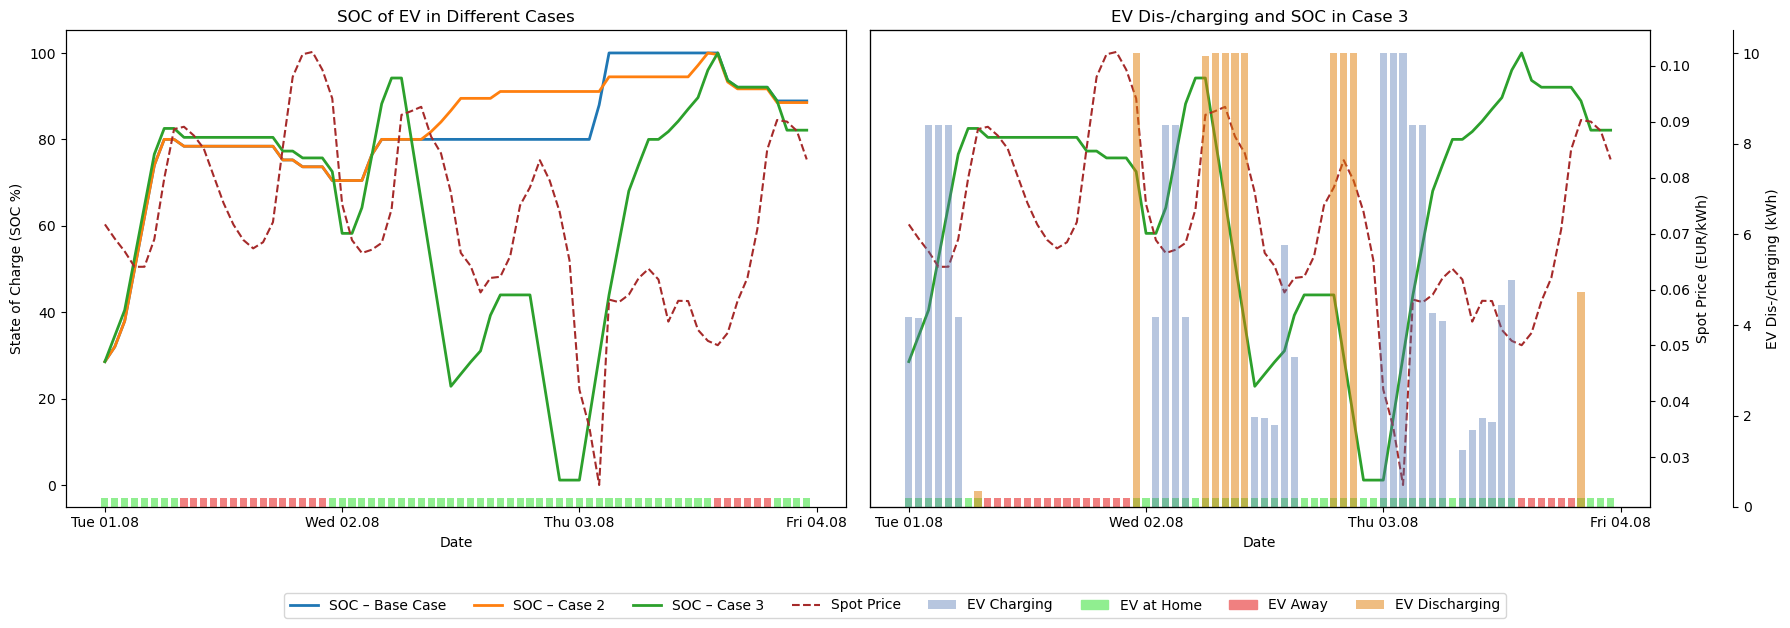

In [106]:
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer
}

plot_ev_soc_and_charging_side_by_side(
    df_dict,
    title_left="SOC of EV in Different Cases",
    title_right="EV Dis-/charging and SOC in Case 3",
    save_filename="SOC_and_charging_cases.png"
)


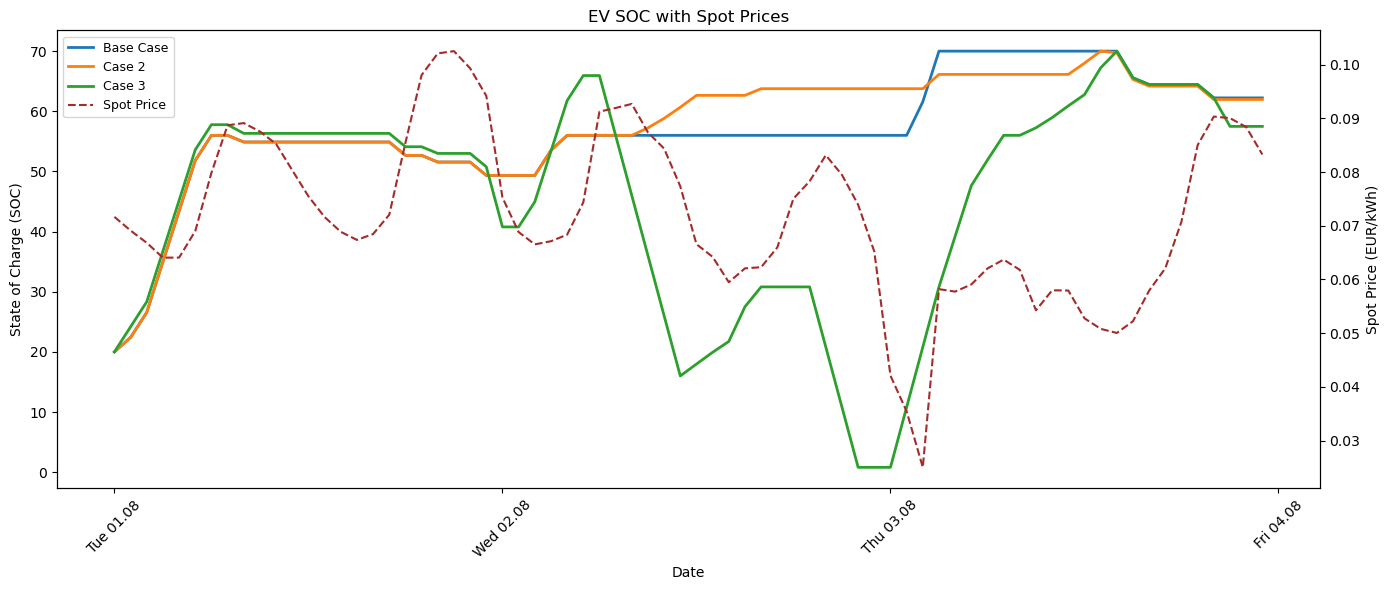

In [26]:
# Example use:
df_dict = {
    "Base Case": results_basecase_summer,
    #"Case 1": results_case_1_summer,
    "Case 2": results_case_2_summer,
    "Case 3": results_case_3_summer,
}

plot_ev_soc_with_price(df_dict)

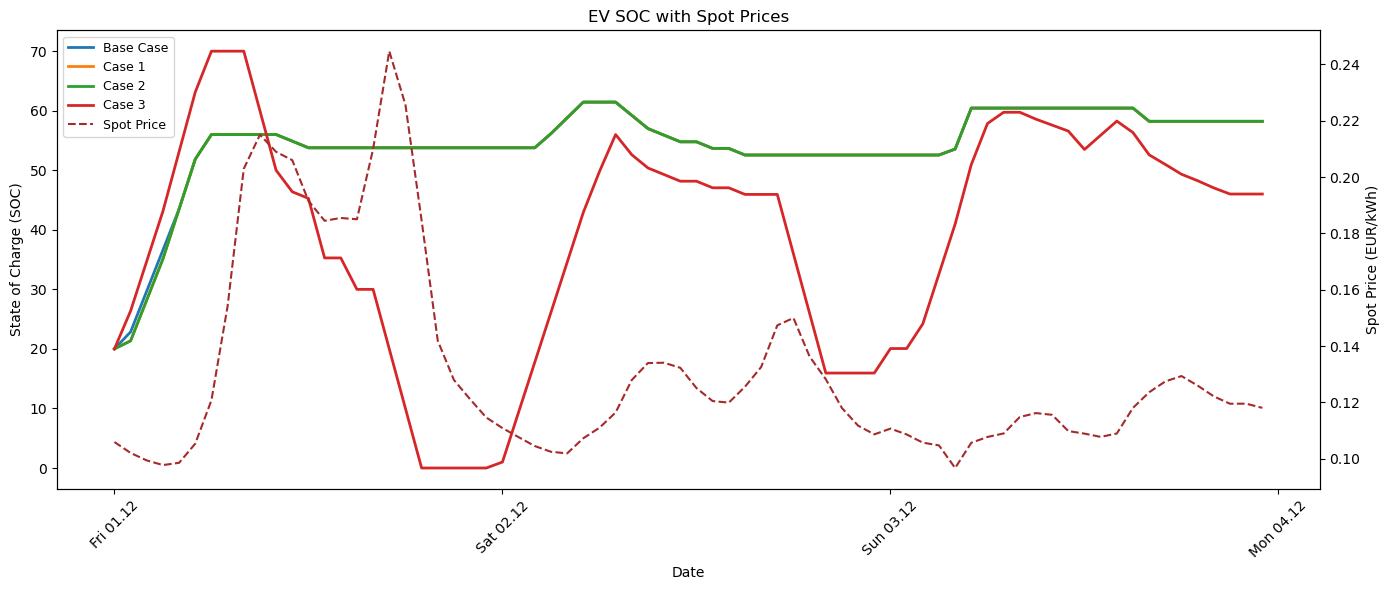

In [27]:
# Example use:
df_dict = {
    "Base Case": results_basecase_winter,
    "Case 1": results_case_1_winter,
    "Case 2": results_case_2_winter,
    "Case 3": results_case_3_winter,
}

plot_ev_soc_with_price(df_dict)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def plot_case3_load_components(
    df,
    title="Case 3 - Load Components Overview",
    save_filename="case3_load_components.png",
    max_time=24 * 7,
):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    timestamps = df['timestamp'][:max_time]

    # Directly available columns
    total_load = df['Total_Demand'][:max_time]
    pv_to_home = df['PV2H'][:max_time]
    ev_v2h = df['EV_V2H'][:max_time]
    ev_v2g = df['EV_V2G'][:max_time]
    unmet = df['Unmet'][:max_time]

    # Inflexible load calculated from binary appliance signals
    inflexible_load =  df['Inflexible_Demand_(kWh)'][:max_time]

    plt.figure(figsize=(14, 6))

    plt.plot(timestamps, total_load, label='Total Load', linewidth=2)
    plt.plot(timestamps, inflexible_load, label='Inflexible Load', linewidth=2)
    plt.plot(timestamps, pv_to_home, label='PV to Home (PV2H)', linestyle='--', linewidth=2)
    plt.plot(timestamps, ev_v2h, label='EV V2H', linestyle='--', linewidth=2)
    plt.plot(timestamps, ev_v2g, label='EV V2G', linestyle='--', linewidth=2)
    plt.plot(timestamps, unmet, label='Unmet Demand', linestyle=':', linewidth=2, color='red')

    plt.xlabel("Date")
    plt.ylabel("Power (kWh)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)

    plt.show()



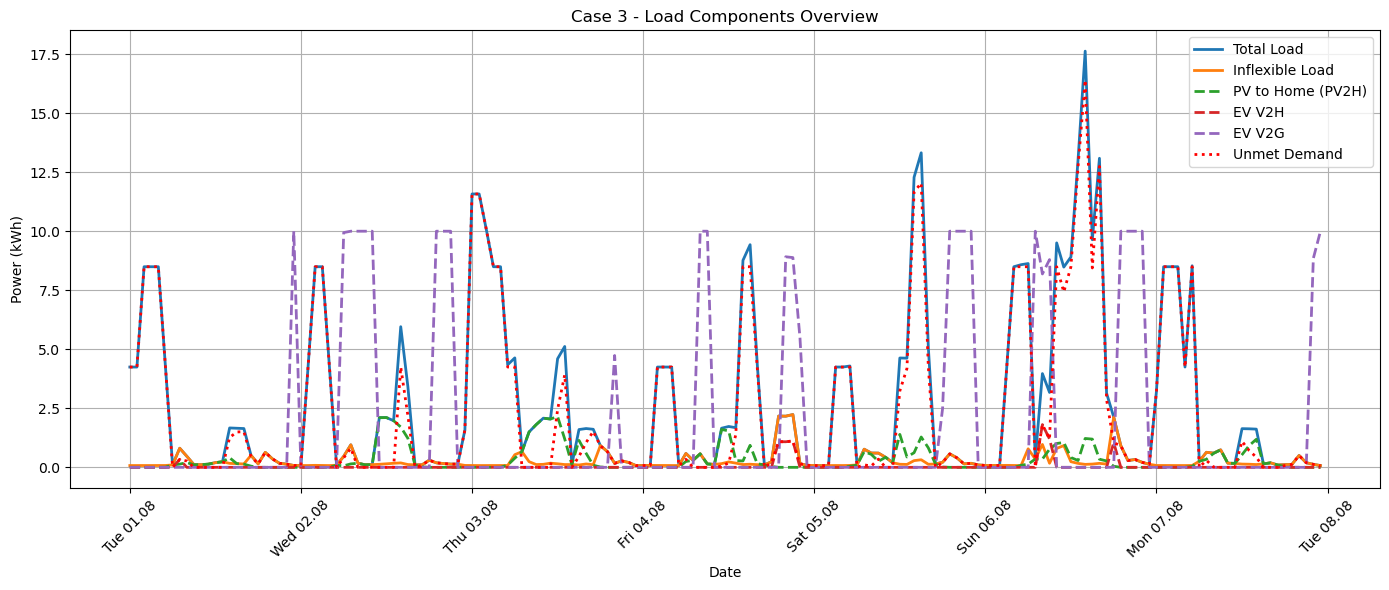

In [11]:

# Call the function with your DataFrame
plot_case3_load_components(results_case_3_summer)




In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

def plot_case2_load_components(
    df,
    title="Case 3 - Load Components Overview",
    save_filename="case3_load_components.png",
    max_time=24 * 7,
):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    timestamps = df['timestamp'][:max_time]

    # Directly available columns
    total_load = df['Total_Demand'][:max_time]
    pv_to_home = df['PV_energy_production_kWh'][:max_time]
    #ev_v2h = df['EV_V2H'][:max_time]
    unmet = df['Unmet'][:max_time]

    # Inflexible load calculated from binary appliance signals
    inflexible_load =  df['Inflexible_Demand_(kWh)'][:max_time]

    plt.figure(figsize=(14, 6))

    plt.plot(timestamps, total_load, label='Total Load', linewidth=2)
    plt.plot(timestamps, inflexible_load, label='Inflexible Load', linewidth=2)
    plt.plot(timestamps, pv_to_home, label='PV electricity production', linestyle='--', linewidth=2)
    #plt.plot(timestamps, ev_v2h, label='EV V2H', linestyle='--', linewidth=2)
    plt.plot(timestamps, unmet, label='Unmet Demand', linestyle=':', linewidth=2, color='red')

    plt.xlabel("Date")
    plt.ylabel("Power (kWh)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.tight_layout()

    if 'figures_dir' in globals():
        plt.savefig(os.path.join(figures_dir, save_filename), dpi=300)
    else:
        plt.savefig(save_filename, dpi=300)

    plt.show()


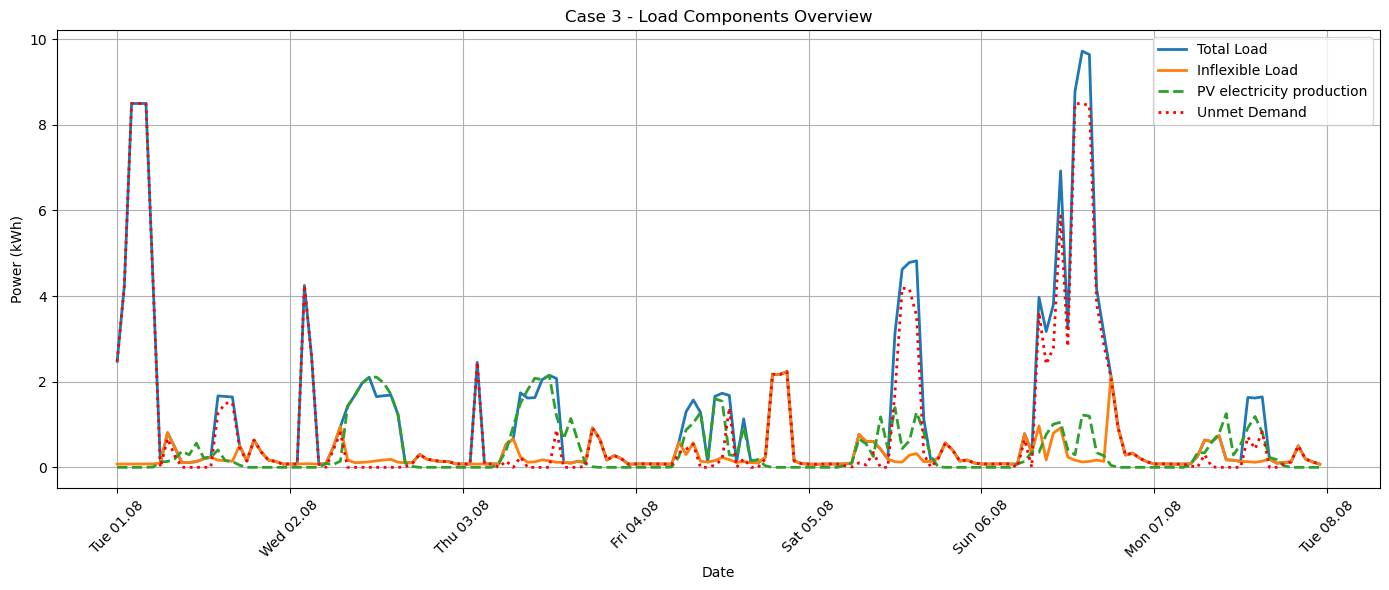

In [13]:
plot_case2_load_components(results_case_2_summer)